## Load Libraries and CSV files

In [4]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats

## Data Wrangling and Cleaning

In [12]:
#read downloaded csv files as data frames

reviews=pd.read_csv('/Users/anna/Downloads/reviews.csv.gz',compression='gzip')
listings=pd.read_csv('/Users/anna/Downloads/listings (1).csv',error_bad_lines=False)
neighborhoods=pd.read_csv('/Users/anna/Downloads/neighbourhoods.csv',error_bad_lines=False)

We take a better look at our datasets and aim to create a main dataframe that gives us all the information we can get for each Airbnb listing

First, we check for null values:

In [13]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249466 entries, 0 to 1249465
Data columns (total 6 columns):
listing_id       1249466 non-null int64
id               1249466 non-null int64
date             1249466 non-null object
reviewer_id      1249466 non-null int64
reviewer_name    1249466 non-null object
comments         1249032 non-null object
dtypes: int64(3), object(3)
memory usage: 57.2+ MB


In [17]:
#There are null values on the comments column (empty reviews). Since this just makes up for .03% of the rows,
#we drop it from the data frame.

reviews=reviews.dropna()

In [18]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80767 entries, 0 to 80766
Data columns (total 16 columns):
id                                80767 non-null int64
name                              80740 non-null object
host_id                           80767 non-null int64
host_name                         80718 non-null object
neighbourhood_group               0 non-null float64
neighbourhood                     80767 non-null object
latitude                          80767 non-null float64
longitude                         80767 non-null float64
room_type                         80767 non-null object
price                             80767 non-null int64
minimum_nights                    80767 non-null int64
number_of_reviews                 80767 non-null int64
last_review                       60194 non-null object
reviews_per_month                 60194 non-null float64
calculated_host_listings_count    80767 non-null int64
availability_365                  80767 non-null int64
dt

There are three columns that contain null values: `neighbourhood_group`, `last_review`, `reviews_per_month`. We can drop the `neighbourhood_group` column since we already have the `neighbourhood` column. As for the other two, we can fill the null values with 0 since this just means that there were no reviews for those listings.

In [24]:
listings=listings.drop('neighbourhood_group',axis=1).fillna(0)

## Feature Engineering

We add more variables that will give us a better idea about each listing.

In [28]:
#check which listings have not been active

inactive=listings.loc[listings.availability_365==365]
new_listings=listings.drop(inactive.index,axis=0)

Since we're interested in knowing how many times a listing has cancelled on a guest, we create a new column containing this information and make it our target variable.

In [29]:
#check automated postings
autopost_1=reviews[reviews.comments.str.contains('The host canceled my reservation')]
autopost_2=reviews[reviews.comments.str.contains('This is an automated posting')]

By checking autopost_1 and autopost_2 dates, we see that the automated posting changed in 2012. To make sure we include all automated cancellation postings, we create a new df "autopost" containing all automated postings.

In [30]:
autopost=pd.concat([autopost_1,autopost_2], axis=0).reset_index()
autopost.head()

,index,listing_id,id,date,reviewer_id,reviewer_name,comments
0,136,24328,221644,2011-04-10,315279,Craig,The host canceled my reservation 38 days befor...
1,431,26482,137001,2010-11-10,278167,Benjamin,The host canceled my reservation 52 days befor...
2,3639,47369,115767,2010-10-10,112795,Cédric,The host canceled my reservation the day befor...
3,3641,47369,129136,2010-10-28,251752,Mélanie,The host canceled my reservation 5 days before...
4,3646,47369,166592,2011-01-06,218191,Sharon,The host canceled my reservation the day befor...


In [31]:
#add a new column showing the number of cancellations made by each listing

canceled=autopost.listing_id.value_counts()
num_cancel=canceled.to_frame(name='cancellations')

new_listings['num_cancellations']=num_cancel
new_listings[:2]

,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,num_cancellations
id,,,,,,,,,,,,,,,
11551,Stylish and bright London apartment in Zone 2,43039,Adriano,Lambeth,51.46225,-0.11732,Entire home/apt,88,2,183,2018-08-22,1.65,2,290,NaN
13913,Holiday London DB Room Let-on going,54730,Alina,Islington,51.56802,-0.11121,Private room,65,1,14,2018-06-17,0.13,3,362,1.0


In [33]:
#check the demand of each listing

booked=365-new_listings.availability_365
booked=booked.to_frame('days booked')
df=new_listings.merge(booked, how='left',left_index=True,right_index=True)

In [34]:
#the average number of days left before the reservation when a reservation is canceled


def days_count(text):
    if 'the day before' in text:
        return 1
    else:
        return int(re.findall('\d+', text)[0])

total_days=pd.DataFrame(autopost.comments.apply(days_count))
auto=pd.merge(autopost,total_days,how='left',left_index=True,right_index=True)
auto.head()
 

,index,listing_id,id,date,reviewer_id,reviewer_name,comments_x,comments_y
0,136,24328,221644,2011-04-10,315279,Craig,The host canceled my reservation 38 days befor...,38
1,431,26482,137001,2010-11-10,278167,Benjamin,The host canceled my reservation 52 days befor...,52
2,3639,47369,115767,2010-10-10,112795,Cédric,The host canceled my reservation the day befor...,1
3,3641,47369,129136,2010-10-28,251752,Mélanie,The host canceled my reservation 5 days before...,5
4,3646,47369,166592,2011-01-06,218191,Sharon,The host canceled my reservation the day befor...,1


In [35]:
avg_days=pd.DataFrame(auto[['listing_id','comments_y']].groupby('listing_id')['comments_y'].apply(np.mean).apply(round))
df['days_cancelled_avg']=avg_days

In [37]:
crime=pd.read_csv('/Users/anna/Downloads/crime rates.csv',error_bad_lines=False).dropna()

conv = lambda x: float(x.replace(',',''))

crime['Number_of_offences']=crime.Number_of_offences.apply(conv)

all_crimes=crime[crime['Offences']=='All recorded offences']

#crime includes 'Inner London','England & Wales','Met Police Area','Outer London' and 'Heathrow',
#which are not official London boroughs, so we drop these from our crime data

#the crime data doesn't include City of London (which is one of the neighbourhoods in our main data) 
#since it's not one of the 32 official London boroughs


all_crimes=all_crimes[all_crimes['Borough']!='Inner London']
all_crimes=all_crimes[all_crimes['Borough']!='England and Wales']
all_crimes=all_crimes[all_crimes['Borough']!='Met Police Area']
all_crimes=all_crimes[all_crimes['Borough']!='Outer London']
all_crimes=all_crimes[all_crimes['Borough']!='Heathrow']

conv_fl = lambda x: int(x.replace('-',''))
year = all_crimes.Year.apply(conv_fl)
all_crimes['Year']=year
latest=all_crimes[(all_crimes['Year'])>=201112]
df_main=pd.merge(df,latest.groupby('Borough').mean(),left_on='neighbourhood',right_on='Borough',how='left')

In [39]:
df_main.head()

,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,num_cancellations,days booked,days_cancelled_avg,Year,Rate,Number_of_offences
0,Stylish and bright London apartment in Zone 2,43039,Adriano,Lambeth,51.46225,-0.11732,Entire home/apt,88,2,183,2018-08-22,1.65,2,290,NaN,75,NaN,201364.5,106.883333,33773.000000
1,Holiday London DB Room Let-on going,54730,Alina,Islington,51.56802,-0.11121,Private room,65,1,14,2018-06-17,0.13,3,362,1.0,3,53.0,201364.5,119.866667,26185.500000
2,Bright Chelsea Apartment. Chelsea!,60302,Philippa,Kensington and Chelsea,51.48796,-0.16898,Entire home/apt,100,3,84,2019-04-22,0.74,1,155,NaN,210,NaN,201364.5,122.566667,19214.166667
3,Superb 3-Bed/2 Bath & Wifi: Trendy W1,67564,Liz,Westminster,51.52098,-0.14002,Entire home/apt,300,3,40,2019-04-20,0.40,13,230,NaN,135,NaN,201364.5,233.100000,53713.333333
4,Battersea bedroom & office w parking shared ga...,41759,Joe,Wandsworth,51.47298,-0.16376,Entire home/apt,175,30,92,2016-09-07,0.89,1,332,3.0,33,33.0,201364.5,74.266667,23127.000000


## Study Trends 

**Which neighborhoods have the most Airbnb listings?**

In [41]:
df_g=df.groupby('neighbourhood').sum()[['number_of_reviews','num_cancellations']]
df_g['total_listings']=df.neighbourhood.value_counts()
df_g=df_g.reset_index()

Text(0.5, 1.0, 'Total Listings per Neighborhood')

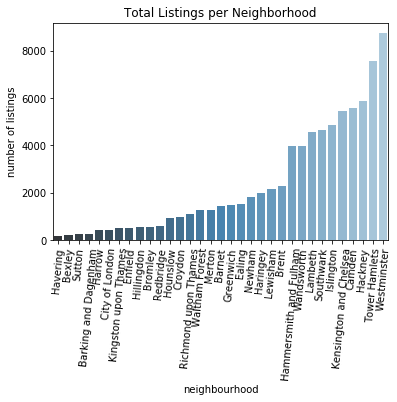

In [42]:
df_g=df_g.sort_values(by=['total_listings'])
sns.barplot(x='neighbourhood',y='total_listings',data=df_g,palette=("Blues_d"))
plt.ylabel('number of listings')
plt.xticks(rotation=85)
plt.title('Total Listings per Neighborhood')

**Which neighborhoods have the most Airbnb reviews?**

Text(0.5, 1.0, 'Total Reviews per Neighborhood')

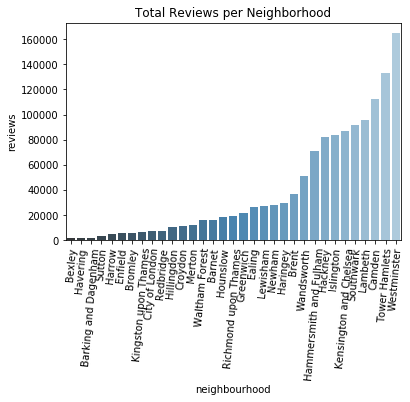

In [43]:
df_g=df_g.sort_values(by=['number_of_reviews'])
sns.barplot(x='neighbourhood',y='number_of_reviews',data=df_g,palette=("Blues_d"))
plt.ylabel('reviews')
plt.xticks(rotation=85)
plt.title('Total Reviews per Neighborhood')

**Which Neighborhoods have the most Airbnb cancellations?**

Text(0.5, 1.0, 'Total Cancellations Per Neighbourhood')

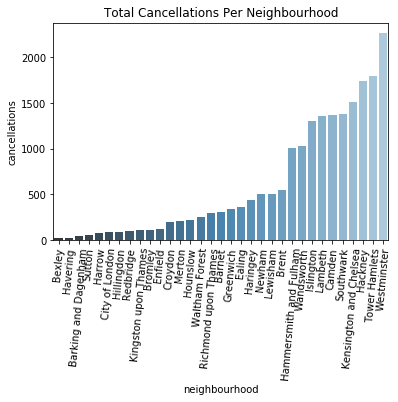

In [44]:
df_g=df_g.sort_values(by=['num_cancellations'])
sns.barplot(x='neighbourhood',y='num_cancellations',data=df_g,palette=("Blues_d"))
plt.ylabel('cancellations')
plt.xticks(rotation=85)
plt.title('Total Cancellations Per Neighbourhood')

**We see that Westminister has the most number of cancellations but also has the most number of Airbnb listings, so looking at the total number of cancellations alone would not be a good metric. We need to take into account the listings each neighborhood has since it varies.**

Text(0.5, 1.0, 'Cancellations-Listing Ratio Per Neighbourhood')

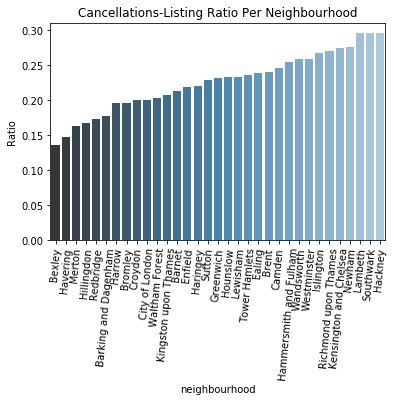

In [45]:
df_g['ratio']=df_g.num_cancellations/df_g.total_listings
df_g=df_g.sort_values(by=['ratio'])

sns.barplot(x='neighbourhood',y='ratio',data=df_g,palette=("Blues_d"))
plt.ylabel('Ratio')
plt.xticks(rotation=85)
plt.title('Cancellations-Listing Ratio Per Neighbourhood')


**Is there a relationship between 'days booked' and 'num_cancellations'?**

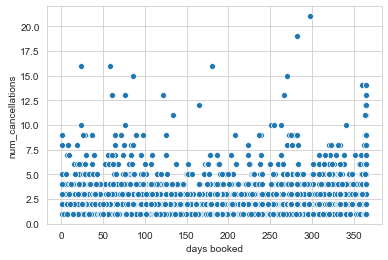

In [46]:
sns.set_style('whitegrid')
sns.scatterplot(x='days booked',y='num_cancellations',data=df)

**Does price correlate with these cancellations?**

Text(0.5, 1.0, 'Histogram of Listing Prices')

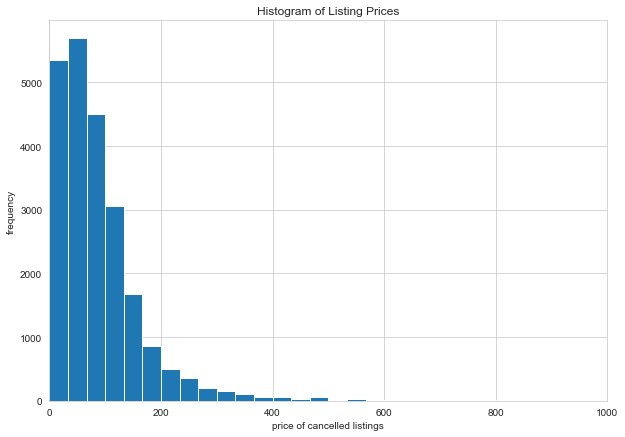

In [47]:
price_cancel=autopost.merge(new_listings,how='left',left_on='listing_id',right_on='id')['price'].fillna(0)

f, ax = plt.subplots(figsize=(10,7))
plt.xlim(xmax = 1000)
_=plt.hist(price_cancel,bins=150)
plt.xlabel('price of cancelled listings')
plt.ylabel('frequency')
plt.title('Histogram of Listing Prices')


**Based on the room type, which neighborhoods are the most expensive?**

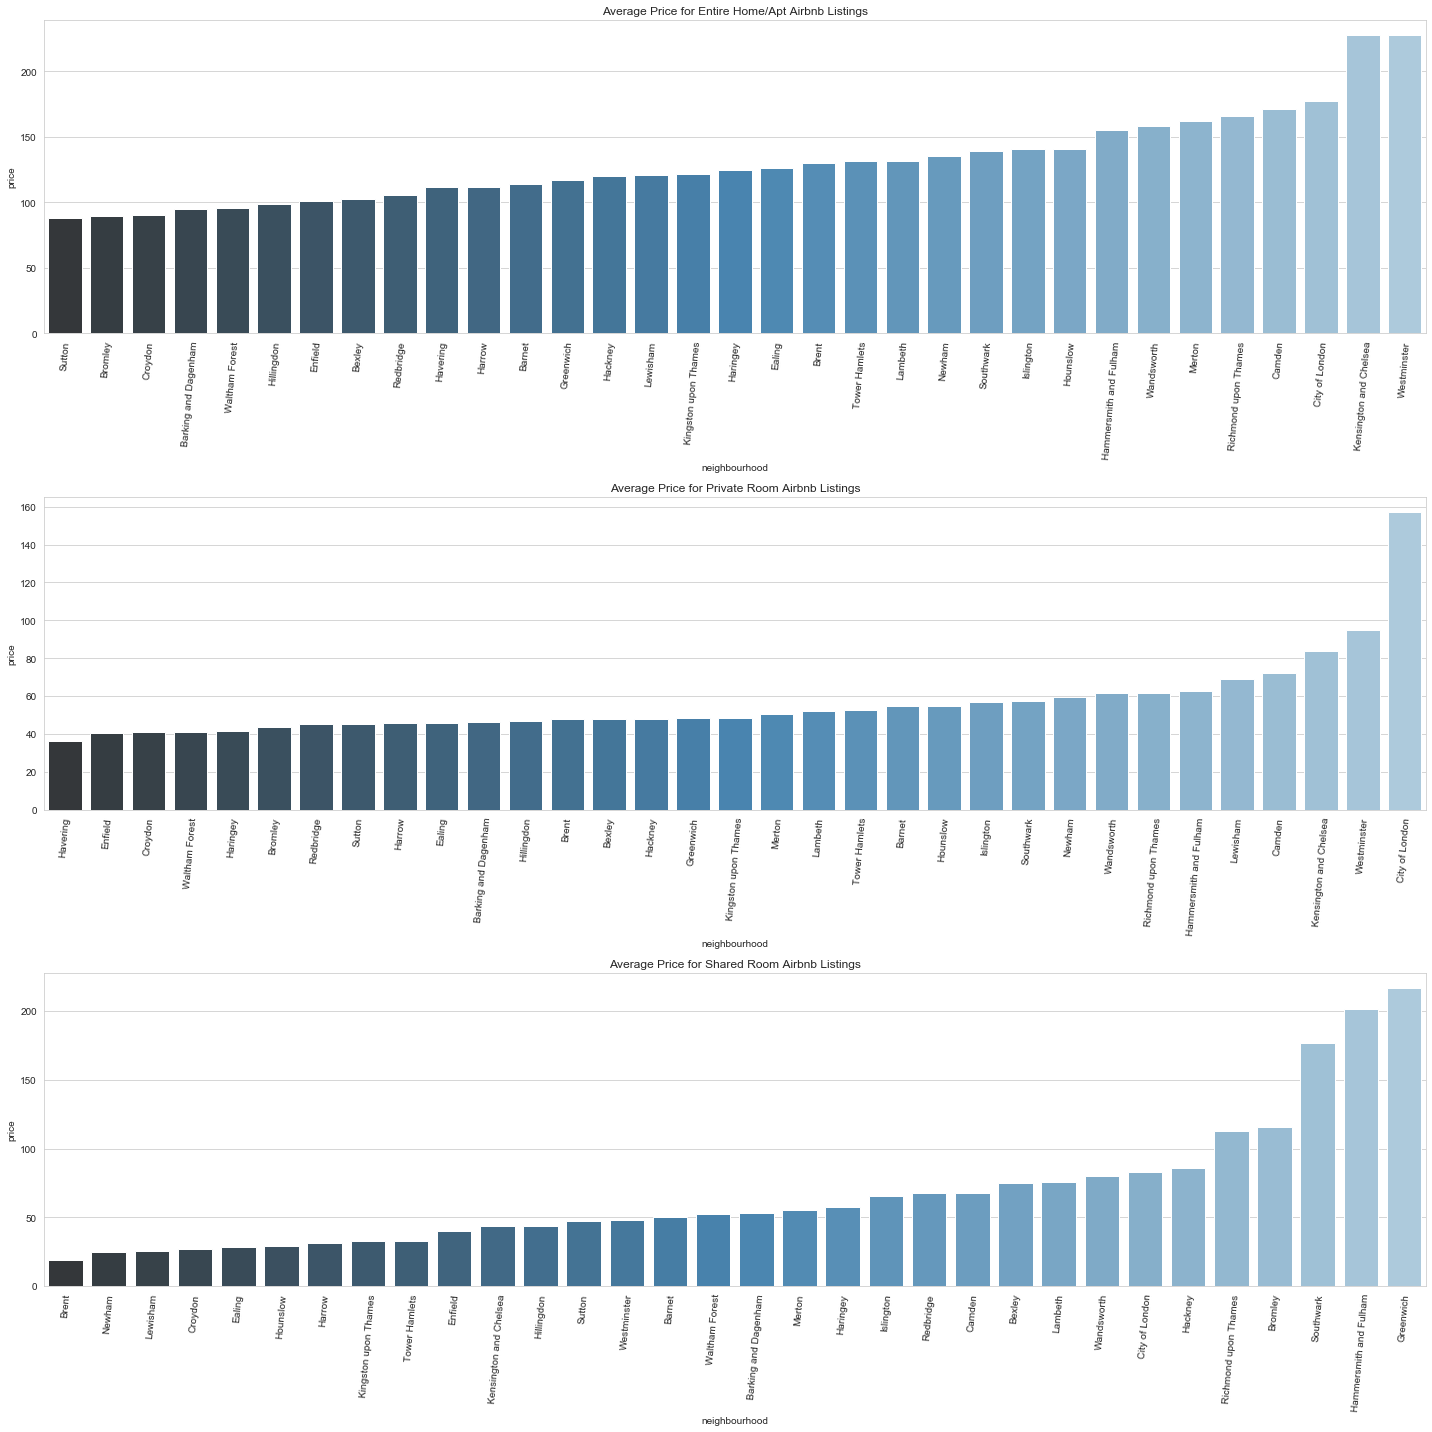

In [48]:
f, ax = plt.subplots(figsize=(20,20))
plt.subplot(3,1,1)

df1=df[df.room_type=='Entire home/apt'].groupby('neighbourhood').mean().reset_index()[['neighbourhood','price']]
sns.barplot(x='neighbourhood',y='price',data=df1.sort_values(by=['price']),palette='Blues_d')
plt.xticks(rotation=85)
plt.title('Average Price for Entire Home/Apt Airbnb Listings')

plt.subplot(3,1,2)
df2=df[df.room_type=='Private room'].groupby('neighbourhood').mean().reset_index()[['neighbourhood','price']]
_=sns.barplot(x='neighbourhood',y='price',data=df2.sort_values(by=['price']),palette='Blues_d')
plt.xticks(rotation=85)
plt.title('Average Price for Private Room Airbnb Listings')
ax.set_xticklabels([])

plt.subplot(3,1,3)
df3=df[df.room_type=='Shared room'].groupby('neighbourhood').mean().reset_index()[['neighbourhood','price']]
sns.barplot(x='neighbourhood',y='price',data=df3.sort_values(by=['price']),palette='Blues_d')
plt.xticks(rotation=85)
plt.title('Average Price for Shared Room Airbnb Listings')

plt.tight_layout()

**What was the room type of the listings cancelled the most?**

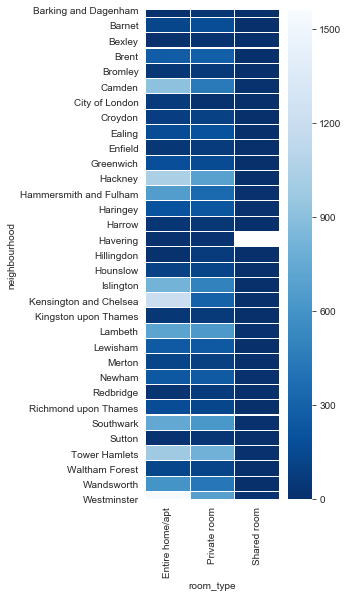

In [49]:
df_pivot2=pd.pivot_table(df,values='num_cancellations', index='neighbourhood',columns='room_type',aggfunc=np.sum)
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(3, 9))
sns.heatmap(df_pivot2,linewidths=.1,ax=ax,cmap=('Blues_r'))

**Which neighborhoods have the highest crime rates?**

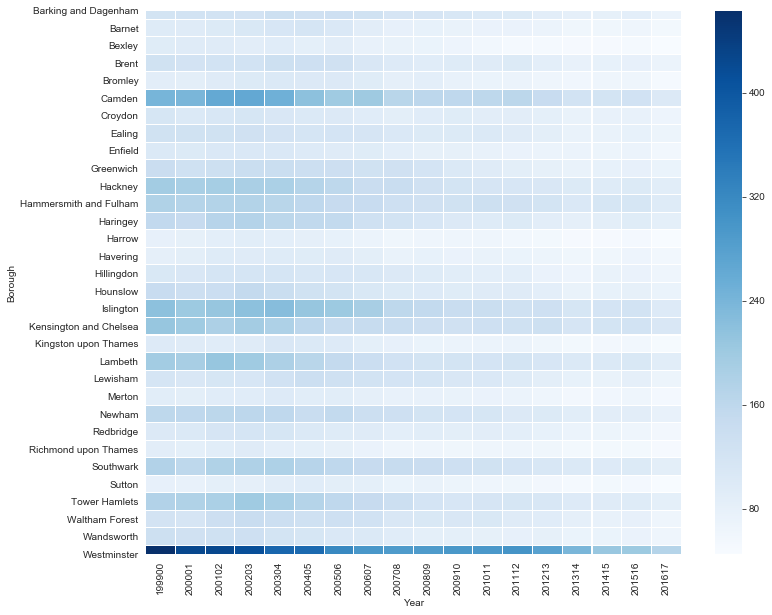

In [50]:
crime_p=pd.pivot_table(all_crimes,values='Rate', index='Borough',columns='Year',aggfunc=np.sum)

f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(crime_p,linewidths=.1,ax=ax,cmap=('Blues'))

**Which neighborhood currently has the highest crime rate?**

Text(0.5, 1.0, 'Crime Rate Per Neighbourhood')

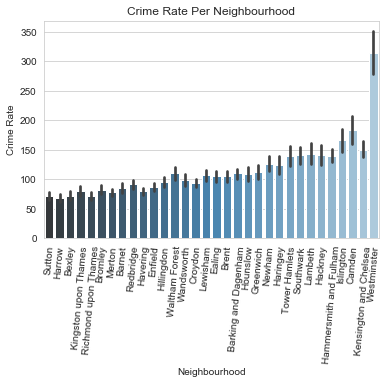

In [51]:
all_crimes=all_crimes.sort_values(by='Rate')
sns.barplot(x='Borough',y='Rate',data=all_crimes,palette='Blues_d')
plt.ylabel('Crime Rate')
plt.xlabel('Neighbourhood')
plt.xticks(rotation=85)
plt.title('Crime Rate Per Neighbourhood')

**Since the crime rates of all neighborhoods have decreased since 1990, we can just focus on the crime rates from 2011 (earliest Airbnb listing in our data) to 2017(latest crime rate data provided by the csv file)**

In [57]:
conv_fl = lambda x: int(str(x).replace('-',''))
year = all_crimes.Year.apply(conv_fl)
all_crimes['Year']=year

latest=all_crimes[(all_crimes['Year'])>=201112]
latest[:2]

,Code,Borough,Year,Offences,Rate,Number_of_offences
656,E09000029,Sutton,201617,All recorded offences,45.0,9102.0
642,E09000015,Harrow,201617,All recorded offences,45.5,11309.0


Text(0.5, 1.0, 'Crime Rate Per Neighbourhood 2011-17')

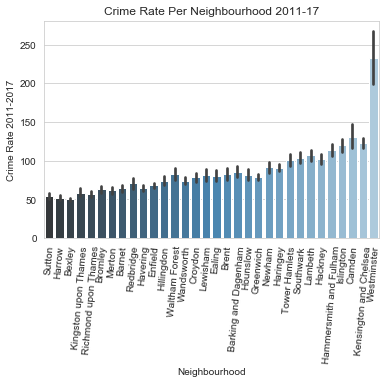

In [58]:
latest=latest.sort_values(by=['Rate'])
sns.barplot(x='Borough',y='Rate',data=latest,palette='Blues_d')
plt.ylabel('Crime Rate 2011-2017')
plt.xlabel('Neighbourhood')
plt.xticks(rotation=85)
plt.title('Crime Rate Per Neighbourhood 2011-17')

Text(0.5, 1.0, 'Crime Rate vs Number of Cancellations')

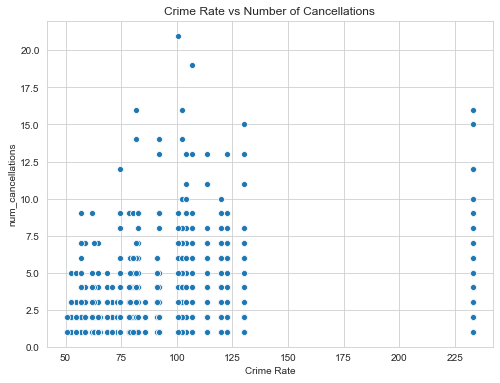

In [59]:
df_main=pd.merge(df,latest.groupby('Borough').mean(),left_on='neighbourhood',right_on='Borough',how='left')

f, ax = plt.subplots(figsize=(8,6))

sns.set_style('whitegrid')
sns.scatterplot(x='Rate',y='num_cancellations',data=df_main)
plt.xlabel('Crime Rate')
plt.title('Crime Rate vs Number of Cancellations')


Text(0.5, 1.0, 'Crime Rate vs Price')

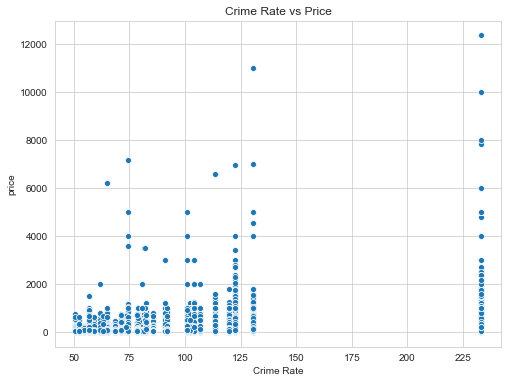

In [60]:
f, ax = plt.subplots(figsize=(8,6))

sns.set_style('whitegrid')
sns.scatterplot(x='Rate',y='price',data=df_main)
plt.xlabel('Crime Rate')
plt.title('Crime Rate vs Price')


## Inferential Statistics

After studying trends between the Airbnb listings, we apply inferential statistics techniques to see if any of these relationships are statistically significant. We mainly focus on how these features are related to the number of cancellations of the listings. 

For most of the variables, we make use of permutation tests to see if their respective correlations with the number of cancellations are statistically significant. 


**Cancellations vs Price**

Null Hypothesis: There is no significant correlation between the number of cancellations vs the price of the listing.

Alternative Hypothesis: There is a significant correlation between the two.

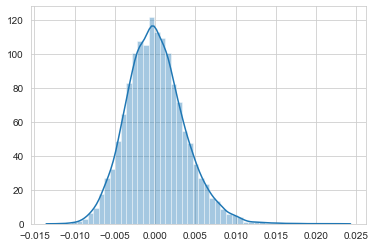

observed correlation between price and number of cancellations: -0.02526
p-value: 0.0000000000
We reject the null. There is a significant correlation between price and number of cancellations


In [61]:
price=pd.DataFrame(df[df.price!=0]['price'])
cancel=pd.DataFrame(df.num_cancellations.fillna(0))
price_cancel = price.merge(cancel,how='left',left_index=True,right_index=True)

#actual correlation between the two
c1=stats.pearsonr(price_cancel.price,price_cancel.num_cancellations)[0]


#bootstrapping

corr_replicates=np.empty(10000)

for i in range(10000):
    price_perm=np.random.permutation(price_cancel.price)
    corr_replicates[i]=stats.pearsonr(price_perm,price_cancel.num_cancellations)[0]

_=sns.distplot(corr_replicates)
plt.show()


p1 = (np.sum(np.abs(corr_replicates)>=np.abs(c1))/10000)

print('observed correlation between price and number of cancellations: %.5f'%c1)
print('p-value: %.10f' % p1)

if p1>0.01:
    print('We fail to reject the null. There is no significant correlation between price and number of cancellations')
else:
    print('We reject the null. There is a significant correlation between price and number of cancellations')



**Cancellations vs Popularity (Number of Reviews)**

Null Hypothesis: There is no significant correlation between the number of cancellations vs the number of reviews a listing gets.

Alternative Hypothesis: There is a significant correlation between the two.

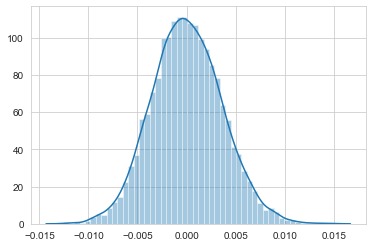

observed correlation between number of reviews and number of cancellations: 0.21254
p-value: 0.0000000000
We reject the null. There is a significant correlation between between the number of cancellations and number of reviews


In [62]:
#actual correlation between the two
c2=stats.pearsonr(df.number_of_reviews,cancel.num_cancellations)[0]


#bootstrapping

corr_replicates=np.empty(10000)

for i in range(10000):
    rev_perm=np.random.permutation(df.number_of_reviews)
    corr_replicates[i]=stats.pearsonr(rev_perm,cancel.num_cancellations)[0]

_=sns.distplot(corr_replicates)
plt.show()


p2 = (np.sum(np.abs(corr_replicates)>=np.abs(c2))/10000)

print('observed correlation between number of reviews and number of cancellations: %.5f'%c2)
print('p-value: %.10f' % p2)

if p2>0.01:
    print('We fail to reject the null. There is no significant correlation between the number of cancellations and number of reviews')
else:
    print('We reject the null. There is a significant correlation between between the number of cancellations and number of reviews')
    

**Cancellations vs Demand(Days Booked)**

Null Hypothesis: There is no significant correlation between the number of cancellations and the number of days the listing is booked.

Alternative Hypothesis: There is a significant correlation between the two.

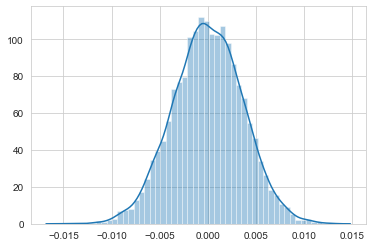

observed correlation between number of days booked and number of cancellations: -0.01100
p-value: 0.0024000000
We reject the null. There is a significant correlation between the number of cancellations and the number of days the listing is booked.


In [63]:
#actual correlation between the two
c3=stats.pearsonr(df['days booked'],cancel.num_cancellations)[0]


#bootstrapping

corr_replicates=np.empty(10000)

for i in range(10000):
    days_perm=np.random.permutation(df['days booked'])
    corr_replicates[i]=stats.pearsonr(days_perm,cancel.num_cancellations)[0]

_=sns.distplot(corr_replicates)
plt.show()


p3 = (np.sum(np.abs(corr_replicates)>=np.abs(c3))/10000)

print('observed correlation between number of days booked and number of cancellations: %.5f'%c3)
print('p-value: %.10f' % p3)

if p3>0.05:
    print('We fail to reject the null. There is no significant correlation  between the number of cancellations and the number of days the listing is booked.')
else:
    print('We reject the null. There is a significant correlation between the number of cancellations and the number of days the listing is booked.')
    


**Cancellation vs Minimum Nights**

Null Hypothesis: There is no significant correlation between the number of cancellations and the minimum nights required by a listing.

Alternative Hypothesis: There is a significant correlation between the two.

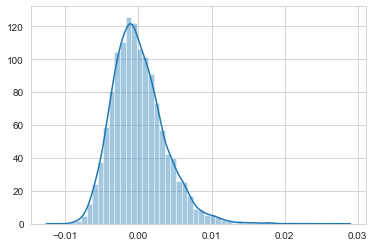

observed correlation between minimum nights and number of cancellations: -0.00473
p-value: 0.1654000000
We fail to reject the null. There is no significant correlation between the number of cancellations and the minimum nights required by a listing.


In [64]:
#actual correlation between the two
c4=stats.pearsonr(df.minimum_nights,cancel.num_cancellations)[0]


#bootstrapping

corr_replicates=np.empty(10000)

for i in range(10000):
    min_perm=np.random.permutation(df.minimum_nights)
    corr_replicates[i]=stats.pearsonr(min_perm,cancel.num_cancellations)[0]

_=sns.distplot(corr_replicates)
plt.show()


p4 = (np.sum(np.abs(corr_replicates)>=np.abs(c4))/10000)

print('observed correlation between minimum nights and number of cancellations: %.5f'%c4)
print('p-value: %.10f' % p4)

if p4>0.01:
    print('We fail to reject the null. There is no significant correlation between the number of cancellations and the minimum nights required by a listing.')
else:
    print('We reject the null. There is a significant correlation between the number of cancellations and the minimum nights required by a listing.')



**Cancellation vs Crime Rate**

Null Hypothesis: There is no significant correlation between the number of cancellations and the crime rate of the neighbourhood that the listing belongs in.

Alternative Hypothesis: There is a significant correlation between the number of cancellations and the crime rate of the neighbourhood that the listing belongs in.

In [65]:
#No crime rate info for City of London since it is not one of the offical
#boroughs of London

df_main[df_main['Rate'].isnull()==True].head()
df_main['num_cancellations']=df_main.num_cancellations.fillna(0)
crime_cancel=df_main[df_main.neighbourhood!='City of London']

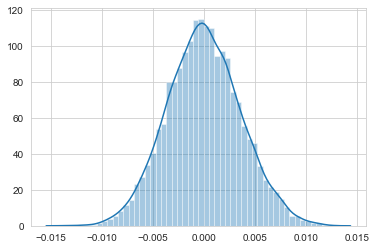

observed correlation between crime rate and number of cancellations: 0.01161
p-value: 0.0008000000
We reject the null. There is a significant correlation between the number of cancellations and the crime rate of the neighbourhood that the listing belongs in.


In [66]:
#actual correlation between the two
c5=stats.pearsonr(crime_cancel.Rate,crime_cancel.num_cancellations)[0]

#bootstrapping

corr_replicates=np.empty(10000)

for i in range(10000):
    crime_perm=np.random.permutation(crime_cancel.Rate)
    corr_replicates[i]=stats.pearsonr(crime_perm,crime_cancel.num_cancellations)[0]

_=sns.distplot(corr_replicates)
plt.show()


p5 = (np.sum(np.abs(corr_replicates)>=np.abs(c5))/10000)

print('observed correlation between crime rate and number of cancellations: %.5f'%c5)
print('p-value: %.10f' % p5)

if p5>0.01:
    print('We fail to reject the null. There is no significant correlation between the number of cancellations and the crime rate of the neighbourhood that the listing belongs in.')
else:
    print('We reject the null. There is a significant correlation between the number of cancellations and the crime rate of the neighbourhood that the listing belongs in.')


**Cancellation by Neighborhood?**

Null Hypothesis: The average number of cancellations of each neighbourhood are not statistically different from each other.

Alternative Hypothesis: The average number of cancellations of each neighbourhood are statistically different from each other.

In [67]:
neighbourhood=list(set(df.neighbourhood))
df['num_cancellations']=df.num_cancellations.fillna(0)

In [68]:
f_results=stats.f_oneway(np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[0]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[1]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[2]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[3]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[4]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[5]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[6]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[7]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[8]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[9]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[10]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[11]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[12]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[13]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[14]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[15]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[16]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[17]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[18]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[19]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[20]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[21]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[22]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[23]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[24]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[25]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[26]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[27]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[28]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[29]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[30]]),np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[31]]),\
               np.array(df['num_cancellations'][df['neighbourhood']==neighbourhood[32]]))


In [69]:
print('f-stat: %.5f'%f_results[0])
print('p-value:%.10f'%f_results[1])

if f_results[1]>0.05:
    print('The average number of cancellations of each neighbourhood are not statistically different from each other.')
else:
    print('The average number of cancellations of each neighbourhood are statistically different from each other.')

f-stat: 4.65329
p-value:0.0000000000
The average number of cancellations of each neighbourhood are statistically different from each other.


**Cancellation by Room Type?**

Null Hypothesis: The average number of cancellations of each room type are not statistically different from each other.

Alternative Hypothesis: The average number of cancellations of each room type are statistically different from each other.

In [70]:
room=list(set(df.room_type))


In [71]:
f_results2=stats.f_oneway(np.array(df['num_cancellations'][df['room_type']==room[0]]),np.array(df['num_cancellations'][df['room_type']==room[1]])\
                         ,np.array(df['num_cancellations'][df['room_type']==room[2]]))

print('f-stat: %.5f'%f_results2[0])
print('p-value:%.10f'%f_results2[1])

if f_results2[1]>0.05:
    print('The average number of cancellations of each room type are not statistically different from each other.')
else:
    print('The average number of cancellations of each room type are statistically different from each other.')

f-stat: 11.68846
p-value:0.0000084047
The average number of cancellations of each room type are statistically different from each other.


## In-Depth Analysis Through Machine Learning

After checking which variables are statistically significant to our target variable, num_of_cancellations, we proceed to choose which machine learning model best suites our project.

In this study, we try out six different models:
- Linear Regression
- Ridge Regression
- Lasso Regression
- Decision Trees
- Gradient Boosting 
- Random Forest


In [72]:
df=df[['neighbourhood','room_type','price','minimum_nights','number_of_reviews'\
       ,'calculated_host_listings_count','days booked','num_cancellations','days_cancelled_avg']]
df['num_cancellations']=df.num_cancellations.fillna(0)
df['days_cancelled_avg']=df.days_cancelled_avg.fillna(0)


In [73]:
df_main=pd.merge(df,latest.groupby('Borough').mean(),left_on='neighbourhood',right_on='Borough',how='left').drop(columns=['Year','Number_of_offences'])

Since scikit learn rejects categorical features by default, we make sure to create dummies for these categorical features. In this data, we only have two categorical variables: 'room_type' and 'neighborhood'.

In [74]:
#create dummies

df=df_main

categories=['room_type','neighbourhood']

for category in categories:
    df[category]=df[category].astype('category')
    
new_df=pd.get_dummies(df,drop_first=True)

X=new_df.drop(columns=['calculated_host_listings_count', 'num_cancellations'])
y=new_df.num_cancellations

We will use 70% of the data as the training data and use the remaining as the test set.

We will fit the training set to different estimators and see which one performs best without any hyperparameter tuning.

## Linear Regression

There are three regression metrics we can use: 
    1) Mean Absolute Error
    2) Mean Squared Error
    3) R^2
    
For this project, I use R^2 for scoring since this will show us the goodness of fit of our prediction compared to the actual values.

In [75]:
X=X.fillna(0)

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)

cv_scores= cross_val_score(reg, X_train, y_train, cv=5,scoring='r2')


print('Linear Regression Cross-Validation Scores:\n',cv_scores)
print("Average Score on 5-Folds: %.2f" % cv_scores.mean())

model_results={}
model_results['Linear Regression']=cv_scores.mean()


Linear Regression Cross-Validation Scores:
 [0.22182906 0.21456582 0.22314043 0.23188513 0.21581316]
Average Score on 5-Folds: 0.22


## Ridge Regression

In [96]:
from sklearn.linear_model import Ridge

ridge = Ridge(random_state=42)
ridge.fit(X_train, y_train)

cv_scores = cross_val_score(ridge, X_train, y_train, cv=5, scoring="r2")

print('Ridge Regression Cross-Validation Scores:\n',cv_scores)
print("Average Score on 5-Folds: %.2f" % cv_scores.mean())


model_results['Ridge Regression']=cv_scores.mean()


Ridge Regression Cross-Validation Scores:
 [0.22183576 0.21456959 0.22314324 0.23189516 0.2158132 ]
Average Score on 5-Folds: 0.22


## Lasso Regression

In [97]:
from sklearn.linear_model import Lasso

lasso = Lasso(random_state=42)
lasso.fit(X_train, y_train)

cv_scores = cross_val_score(lasso, X_train, y_train, cv=5, scoring="r2")



print('Lasso Regression Cross-Validation Scores:\n',cv_scores)
print("Average Score on 5-Folds: %.2f" % (cv_scores.mean()))


model_results['Lasso Regression']=(cv_scores.mean())


Lasso Regression Cross-Validation Scores:
 [0.21074508 0.21117534 0.21896476 0.22656011 0.2144238 ]
Average Score on 5-Folds: 0.22


## Decision Trees

In [98]:
from sklearn import tree
from sklearn.ensemble import BaggingRegressor

trees = tree.DecisionTreeRegressor(random_state=42)
trees.fit(X_train, y_train)

bag = BaggingRegressor(base_estimator=trees, random_state=42)
bag.fit(X_train, np.ravel(y_train))

cv_scores = cross_val_score(bag, X_train, np.ravel(y_train), cv=5, scoring="r2")

print('Decision Trees Cross-Validation Scores:\n',cv_scores)
print("Average Score on 5-Folds: %.2f" % cv_scores.mean())


model_results['Decision Trees']=cv_scores.mean()


Decision Trees Cross-Validation Scores:
 [0.54421732 0.58967052 0.59873293 0.61578467 0.56818362]
Average Score on 5-Folds: 0.58


## Random Forest

In [99]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, np.ravel(y_train))

cv_scores = cross_val_score(rf, X_train, np.ravel(y_train), cv=5, scoring="r2")


print('Random Forest Cross-Validation Scores:\n',cv_scores)
print("Average Score on 5-Folds: %.2f" % cv_scores.mean())

model_results['Random Forest']=cv_scores.mean()

/Users/anna/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Cross-Validation Scores:
 [0.55257612 0.58953325 0.58852658 0.60762948 0.5629142 ]
Average Score on 5-Folds: 0.58


## Gradient Boost 

In [100]:

from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, np.ravel(y_train))

cv_scores = cross_val_score(gbr, X_train, np.ravel(y_train),cv=5, scoring="r2")

print('Gradient Boost Cross-Validation Scores:\n',cv_scores)
print("Average Score on 5-Folds: %.2f" % cv_scores.mean())

model_results['Gradient Boost']=cv_scores.mean()

Gradient Boost Cross-Validation Scores:
 [0.596267   0.63524947 0.6151807  0.68429693 0.63003123]
Average Score on 5-Folds: 0.63


In the dictionary below, we see how well each estimator did.

In [101]:
model_results

{'Linear Regression': 0.22144672182329278,
 'Ridge Regression': 0.22145138975618472,
 'Lasso Regression': 0.21637381583468165,
 'Decision Trees': 0.5833178140921795,
 'Random Forest': 0.5802359261222874,
 'Gradient Boost': 0.6322050662448342}

In [103]:
results

,cv_mean
Gradient Boost,0.632205
Decision Trees,0.583318
Random Forest,0.580236
Ridge Regression,0.221451
Linear Regression,0.221447
Lasso Regression,0.216374


Text(0, 0.5, 'Mean CV Scores')

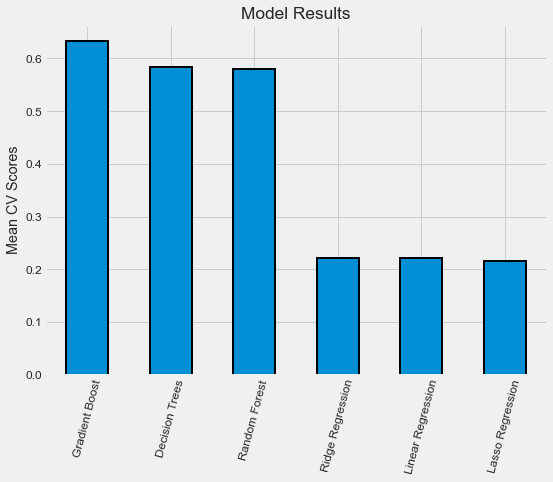

In [102]:
results=pd.DataFrame.from_dict(model_results,orient='index',columns=['cv_mean'])
results=results.sort_values('cv_mean',ascending=False)
results['cv_mean'].plot.bar(figsize = (8, 6), edgecolor = 'k', linewidth = 2)
plt.xticks(rotation=75)
plt.title('Model Results')
plt.ylabel('Mean CV Scores')

The Gradient Boosting Regressor returned the highest cross validation score average. We try to extract best performance from this model by hyperparameter tuning.

## Feature Importance

Despite not having a lot of features to start with (40), we can improve the model's performance by dropping features that do not improve its performance and could even cause an overfitting.

In [84]:
features=X_train.columns

In [85]:
# Feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': features, 'importance': rf.feature_importances_})
feature_importances.sort_values(by='importance',ascending=False)

,feature,importance
4,days_cancelled_avg,0.676218
2,number_of_reviews,0.078718
0,price,0.067696
3,days booked,0.056675
1,minimum_nights,0.026000
5,Rate,0.018954
38,room_type_Private room,0.007126
26,neighbourhood_Lambeth,0.005529
17,neighbourhood_Hammersmith and Fulham,0.005451
24,neighbourhood_Kensington and Chelsea,0.005236


In [86]:
def plot_feature_importances(df, n = 10, threshold = None):
   
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show()
        
        
    
    return df


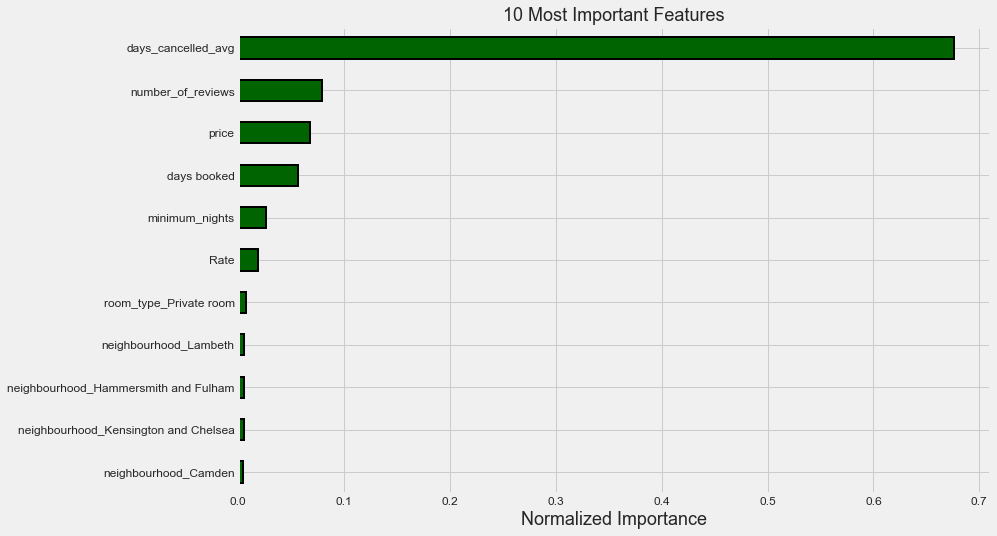

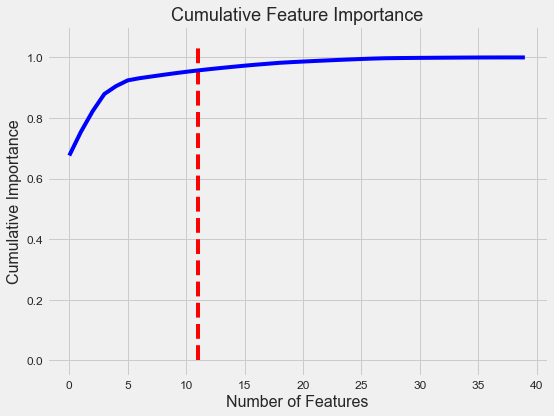

In [87]:
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)

As we can see, the noncategorical feature that has least feature importance is 'Rate' (neighborhood's crime rate).

In [88]:
#create dummies

categories=['room_type','neighbourhood']

for category in categories:
    df_main[category]=df_main[category].astype('category')
    
new=pd.get_dummies(df_main,drop_first=True).drop(columns=['Rate'])

X2=new.drop(columns=['calculated_host_listings_count', 'num_cancellations'])
take_log = lambda x: np.log(x) if x>0 else 0
y2=new.num_cancellations

In [89]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

In [111]:
gbr2 = GradientBoostingRegressor(random_state=42)
gbr2.fit(X2_train, np.ravel(y2_train))

cv_scores = cross_val_score(gbr2, X2_train, np.ravel(y2_train),cv=5, scoring="r2")

print('Gradient Boost Cross-Validation Scores:\n',cv_scores)
print("Average Score on 5-Folds: %.4f" % cv_scores.mean())

Gradient Boost Cross-Validation Scores:
 [0.5957091  0.63590852 0.62215427 0.6849382  0.62910172]
Average Score on 5-Folds: 0.6336


By dropping the feature 'Rate', our average CV score went up from 63.22% to 63.36%

## Hyperparameter Tuning

In [91]:
trees=[50,100,200,300,400,500]

gbr_results={}

for tree in trees:
    gbr2 = GradientBoostingRegressor(random_state=42,n_estimators=tree)
    gbr2.fit(X2_train, np.ravel(y2_train))

    cv_scores = cross_val_score(gbr2, X2_train, np.ravel(y2_train),cv=5, scoring="r2")*100
    gbr_results[tree]=cv_scores.mean()
    
best_n=[a for a,b in gbr_results.items() if b==max(gbr_results.values())][0]

In [92]:
depth= list(range(3,8))

depth_results={}

for x in depth:
    gbr2 = GradientBoostingRegressor(random_state=42,n_estimators=best_n,max_depth=x)
    gbr2.fit(X2_train, np.ravel(y2_train))

    cv_scores = cross_val_score(gbr2, X2_train, np.ravel(y2_train),cv=5, scoring="r2")*100
    depth_results[x]=cv_scores.mean()
    
best_max_depth=[a for a,b in depth_results.items() if b==max(depth_results.values())][0]

In [93]:
lr=[0.0001, 0.001, 0.01, 0.1]

lr_results={}

for x in lr:
    gbr2 = GradientBoostingRegressor(random_state=42,n_estimators=best_n,max_depth=best_max_depth,learning_rate=x)
    gbr2.fit(X2_train, np.ravel(y2_train))

    cv_scores = cross_val_score(gbr2, X2_train, np.ravel(y2_train),cv=5, scoring="r2")*100
    lr_results[x]=cv_scores.mean()
    
best_lr=[a for a,b in lr_results.items() if b==max(lr_results.values())][0]


In [107]:
best={}
best['best_n']=best_n
best['best_max_depth']=best_max_depth
best['best_lr']=best_lr
best

{'best_n': 50, 'best_max_depth': 3, 'best_lr': 0.1}

In [109]:
gbr = GradientBoostingRegressor(random_state=42,n_estimators=best_n,max_depth=best_max_depth,learning_rate=best_lr)
gbr.fit(X_train, np.ravel(y_train))

cv_scores = cross_val_score(gbr, X_train, np.ravel(y_train),cv=5, scoring="r2")

print('Gradient Boost Cross-Validation Scores:\n',cv_scores)
print("Average Score on 5-Folds: %.4f" % cv_scores.mean())


Gradient Boost Cross-Validation Scores:
 [0.59723885 0.63568652 0.62412524 0.68595745 0.63301504]
Average Score on 5-Folds: 0.6352


## Final Result

In [95]:
train_score = gbr.score(X_train, y_train)*100
test_score = gbr.score(X_test, y_test)*100

print("Train set score: %.2f%%" % train_score)
print("Test set score: %.2f%%" % test_score)

Train set score: 64.60%
Test set score: 61.45%


As can be expected, the test set score is less than the train set score. Although, the difference is not much, which indicates that overfitting was not a problem. 

## Limitations

1) The datasets used in this study had limited features and certain information were only available for the current year ("availability_365"). 

2) The model could vastly improve with more data for each listing

